In [26]:
#This project is made by Laila DAMIR, Zineb Choukrani, Oumaima kharbouche, Salma Boulija

In [3]:
from pyspark.sql import SparkSession

# Create Spark session with Delta support
spark = SparkSession.builder \
    .appName("Healthcare Data ETL") \
    .config("spark.jars.packages", "io.delta:delta-core_2.12:1.0.0") \
    .config("spark.sql.extensions", "org.apache.spark.sql.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .getOrCreate()


In [4]:
# Load the CSV data
data_path = "/home/jovyan/BigData/healthcare_dataset.csv"
df = spark.read.option("header", "true").csv(data_path)
df.show()

+--------------------+---+------+----------+-----------------+-----------------+------------------+--------------------+------------------+------------------+-----------+--------------+--------------+-----------+------------+
|                Name|Age|Gender|Blood Type|Medical Condition|Date of Admission|            Doctor|            Hospital|Insurance Provider|    Billing Amount|Room Number|Admission Type|Discharge Date| Medication|Test Results|
+--------------------+---+------+----------+-----------------+-----------------+------------------+--------------------+------------------+------------------+-----------+--------------+--------------+-----------+------------+
|     Tiffany Ramirez| 81|Female|        O-|         Diabetes|       2022-11-17|    Patrick Parker|    Wallace-Hamilton|          Medicare| 37490.98336352819|        146|      Elective|    2022-12-01|    Aspirin|Inconclusive|
|         Ruben Burns| 35|  Male|        O+|           Asthma|       2023-06-01|     Diane Jacks

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, date_format
from pyspark.sql.types import DoubleType

# Initialize Spark session (if not already done)
spark = SparkSession.builder.appName("HealthCareAnalysis").getOrCreate()

# Your initial DataFrame transformation
transformed_df = (
    df.dropna(subset=["Name", "Date of Admission", "Billing Amount"])  # Drop rows with nulls in these columns
    .withColumnRenamed("Billing Amount", "billing_amount")  # Rename for consistency
    .withColumnRenamed("Blood Type", "blood_type")  # Rename to remove space
    .withColumnRenamed("Medical Condition", "medical_condition")  # Rename to remove space
    .withColumnRenamed("Date of Admission", "date_of_admission")  # Rename to remove space
    .withColumnRenamed("Doctor", "doctor")  # Rename to remove space
    .withColumnRenamed("Hospital", "hospital")  # Rename to remove space
    .withColumnRenamed("Insurance Provider", "insurance_provider")  # Rename to remove space
    .withColumnRenamed("Room Number", "room_number")  # Rename to remove space
    .withColumnRenamed("Admission Type", "admission_type")  # Rename to remove space
    .withColumnRenamed("Discharge Date", "discharge_date")  # Rename to remove space
    .withColumnRenamed("Medication", "medication")  # Rename to remove space
    .withColumnRenamed("Test Results", "test_results")  # Rename to remove space
    .withColumn("date_of_admission", to_date(col("date_of_admission"), "yyyy-MM-dd"))  # Correct date format
    .withColumn("billing_amount", col("billing_amount").cast(DoubleType()))  # Cast to DoubleType
    .withColumn("discharge_date", to_date(col("discharge_date"), "yyyy-MM-dd"))  # Cast to DateType
    .select(
        col("Name"),
        col("Age"),  # Include Age column
        col("Gender"),  # Include Gender column
        col("date_of_admission"),
        col("billing_amount"),
        col("blood_type"),
        col("medical_condition"),
        col("doctor"),
        col("hospital"),
        col("insurance_provider"),
        col("room_number"),
        col("admission_type"),
        col("discharge_date"),
        col("medication"),
        col("test_results")
    )
)

# Register the DataFrame as a temporary view
transformed_df.createOrReplaceTempView("healthcare_data")




In [7]:
delta_table_path = "/home/jovyan/BigData/delta_healthcare_data"


In [8]:
transformed_df.createOrReplaceTempView("healthcare_data")
transformed_df.write.csv(delta_table_path, header=True, mode="overwrite")



In [9]:
spark.sql(f"CREATE TABLE IF NOT EXISTS healthcare_data USING DELTA LOCATION '{delta_table_path}'")



DataFrame[]

In [10]:
query_admissions_per_month = """
SELECT
    DATE_FORMAT(`date_of_admission`, 'MMMM yyyy') AS Admission_Month,
    COUNT(1) AS Total_Admissions
FROM
    healthcare_data
WHERE
    `date_of_admission` IS NOT NULL
GROUP BY
    Admission_Month
ORDER BY
    Admission_Month
"""


# Execute the query
df_admissions_per_month = spark.sql(query_admissions_per_month).toPandas()

# Display the result
print(df_admissions_per_month.columns)

Index(['Admission_Month', 'Total_Admissions'], dtype='object')


In [11]:
spark.sql("SELECT * FROM healthcare_data").show()


+--------------------+---+------+-----------------+------------------+----------+-----------------+------------------+--------------------+------------------+-----------+--------------+--------------+-----------+------------+
|                Name|Age|Gender|date_of_admission|    billing_amount|blood_type|medical_condition|            doctor|            hospital|insurance_provider|room_number|admission_type|discharge_date| medication|test_results|
+--------------------+---+------+-----------------+------------------+----------+-----------------+------------------+--------------------+------------------+-----------+--------------+--------------+-----------+------------+
|     Tiffany Ramirez| 81|Female|       2022-11-17| 37490.98336352819|        O-|         Diabetes|    Patrick Parker|    Wallace-Hamilton|          Medicare|        146|      Elective|    2022-12-01|    Aspirin|Inconclusive|
|         Ruben Burns| 35|  Male|       2023-06-01| 47304.06484547511|        O+|           Asth

In [12]:
# Check the schema of the DataFrame
transformed_df.printSchema()


root
 |-- Name: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- date_of_admission: date (nullable = true)
 |-- billing_amount: double (nullable = true)
 |-- blood_type: string (nullable = true)
 |-- medical_condition: string (nullable = true)
 |-- doctor: string (nullable = true)
 |-- hospital: string (nullable = true)
 |-- insurance_provider: string (nullable = true)
 |-- room_number: string (nullable = true)
 |-- admission_type: string (nullable = true)
 |-- discharge_date: date (nullable = true)
 |-- medication: string (nullable = true)
 |-- test_results: string (nullable = true)



In [26]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, month, quarter

# Sample Spark session
spark = SparkSession.builder.appName("HealthcareCubeExample").getOrCreate()

# Assuming `healthcare_data` is already loaded as a DataFrame in Spark
healthcare_data = spark.table("healthcare_data")  # replace with your actual DataFrame

# Cube on Doctor and Date Dimensions (day, month, quarter)
cube_df = healthcare_data.cube("doctor", "Date_of_Admission").agg(count("*").alias("Total_Admissions"))

# Filter for specific aggregations

# 1. Admissions by doctor per day
result_day = cube_df.filter(cube_df.Date_of_Admission.isNotNull())
result_day.show()

# 2. Admissions by doctor per month
result_month = cube_df.withColumn("Admission_Month", month("Date_of_Admission")) \
    .groupBy("doctor", "Admission_Month").agg(count("*").alias("Total_Admissions")) \
    .orderBy("doctor", "Admission_Month")
result_month.show()

# 3. Admissions by doctor per quarter
result_quarter = cube_df.withColumn("Admission_Quarter", quarter("Date_of_Admission")) \
    .groupBy("doctor", "Admission_Quarter").agg(count("*").alias("Total_Admissions")) \
    .orderBy("doctor", "Admission_Quarter")
result_quarter.show()


+-------------------+-----------------+----------------+
|             doctor|Date_of_Admission|Total_Admissions|
+-------------------+-----------------+----------------+
|  Gregory Schroeder|       2021-02-23|               1|
|     Tricia Mcclure|       2021-05-06|               1|
|        Linda Gomez|       2019-09-04|               1|
|    Alice Gross DVM|       2020-12-07|               1|
|      Kenneth Nunez|       2020-03-02|               1|
|       Claire Young|       2022-03-16|               1|
|Francisco Brown PhD|       2023-06-13|               1|
|        Karen Ortiz|       2019-08-29|               1|
|   Francisco Barton|       2023-05-05|               1|
|         Keith Reed|       2019-09-01|               1|
|  Alexis Hutchinson|       2019-07-05|               1|
|        Laura Brown|       2021-12-05|               1|
|    Michael Johnson|       2022-02-20|               1|
|       Matthew Khan|       2020-12-15|               1|
|         Mark Bruce|       202

In [29]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, month, quarter

# Initialize Spark session
spark = SparkSession.builder.appName("HealthcareCubeBilling").getOrCreate()

# Assuming `healthcare_data` is loaded as a DataFrame in Spark
healthcare_data = spark.table("healthcare_data")  # replace with your actual DataFrame if needed

# Create a cube on Doctor and Date_of_Admission, and calculate average billing
cube_df = healthcare_data.cube("doctor", "Date_of_Admission","billing_amount").agg(avg("billing_amount").alias("Average_Billing"))

# Filter and group by different time dimensions

# 1. Average billing amount per doctor by day
result_day = cube_df.filter(cube_df.Date_of_Admission.isNotNull())
result_day.show()

# 2. Average billing amount per doctor by month
result_month = cube_df.withColumn("Admission_Month", month("Date_of_Admission")) \
    .groupBy("doctor", "Admission_Month").agg(avg("billing_amount").alias("Average_Billing")) \
    .orderBy("doctor", "Admission_Month")
result_month.show()

# 3. Average billing amount per doctor by quarter
result_quarter = cube_df.withColumn("Admission_Quarter", quarter("Date_of_Admission")) \
    .groupBy("doctor", "Admission_Quarter").agg(avg("billing_amount").alias("Average_Billing")) \
    .orderBy("doctor", "Admission_Quarter")
result_quarter.show()


+--------------------+-----------------+------------------+------------------+
|              doctor|Date_of_Admission|    billing_amount|   Average_Billing|
+--------------------+-----------------+------------------+------------------+
|         Marcus Reed|       2022-10-31| 18161.75197765212| 18161.75197765212|
|       Jessica Smith|       2021-06-23| 7154.956699857513| 7154.956699857513|
|         Sean Warren|       2020-11-20|21005.634447377277|21005.634447377277|
|   Thomas Hutchinson|       2021-12-13|24954.731136095797|24954.731136095797|
|        John Russell|       2022-08-21|11762.223633738979|11762.223633738979|
|         Steven Lang|       2019-07-09| 43953.82009825218| 43953.82009825218|
|Charles Stevenson MD|       2019-06-05|18322.625425350245|18322.625425350245|
|        Ronald Jones|       2022-02-17|23021.113540007093|23021.113540007093|
|    William Mcknight|       2023-04-21| 17490.76997039526| 17490.76997039526|
|       Jacob Bridges|       2020-07-31|44432.747779

In [31]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when

# Initialize Spark session
spark = SparkSession.builder.appName("HealthcareAgeGenderCube").getOrCreate()

# Load healthcare_data DataFrame (assuming it is already loaded as a Spark DataFrame)
healthcare_data = spark.table("healthcare_data")  # replace with actual DataFrame if needed

# Define age groups using `when` statements
healthcare_data = healthcare_data.withColumn(
    "Age_Group",
    when((healthcare_data.Age.between(0, 20)), "0-20")
    .when((healthcare_data.Age.between(21, 40)), "21-40")
    .when((healthcare_data.Age.between(41, 60)), "41-60")
    .otherwise("61+")
)

# Create a cube on Hospital, Age_Group, and Gender and count patients
cube_df = healthcare_data.cube("Hospital", "Age_Group", "Gender").agg(count("*").alias("Total_Patients"))

# Show results for all combinations
# Show only rows where Hospital, Age_Group, and Gender are not null
result_filtered = cube_df.filter(cube_df.Hospital.isNotNull() & cube_df.Age_Group.isNotNull() & cube_df.Gender.isNotNull())
result_filtered.orderBy("Hospital", "Age_Group", "Gender").show()


+--------------------+---------+------+--------------+
|            Hospital|Age_Group|Gender|Total_Patients|
+--------------------+---------+------+--------------+
|          Abbott Inc|    41-60|  Male|             1|
|          Abbott LLC|    21-40|Female|             1|
|          Abbott LLC|      61+|Female|             1|
|          Abbott PLC|    41-60|  Male|             1|
|Abbott, Curry and...|      61+|Female|             1|
|       Abbott-Jordan|      61+|  Male|             1|
|     Abbott-Phillips|      61+|  Male|             1|
|         Abbott-Shea|    21-40|Female|             1|
|         Acevedo LLC|      61+|  Male|             1|
|    Acevedo and Sons|      61+|  Male|             1|
|Acevedo, Rojas an...|     0-20|Female|             1|
|          Acosta PLC|    21-40|Female|             1|
|     Acosta and Sons|    21-40|  Male|             1|
|Acosta, Saunders ...|    21-40|Female|             1|
|Acosta, Thompson ...|    41-60|Female|             1|
|       Ac

In [42]:
from pyspark.sql import functions as F

# Step 1: Calculate per-day average billing for each doctor
daily_avg_df = healthcare_data.groupBy("doctor", "date_of_admission") \
    .agg(F.avg("billing_amount").alias("avg_billing_amount_per_day"))

# Add a label to indicate daily averages
result_df = daily_avg_df.withColumn("day_type", F.lit("Daily Average"))

# Select and rename columns for final display
result_df = result_df.select(
    F.col("doctor"),
    F.col("date_of_admission").alias("day"),
    F.col("avg_billing_amount_per_day"),
    F.col("day_type")
).orderBy("doctor", "day")

# Display final result
result_df.show()


+-----------------+----------+--------------------------+-------------+
|           doctor|       day|avg_billing_amount_per_day|     day_type|
+-----------------+----------+--------------------------+-------------+
|   Aaron Anderson|2020-03-09|        41518.734350761755|Daily Average|
|    Aaron Barrera|2020-07-14|        17930.808495119258|Daily Average|
|      Aaron Boone|2020-09-13|          39798.2634460689|Daily Average|
|     Aaron Brewer|2023-05-29|         38698.63254075844|Daily Average|
|      Aaron Brown|2019-05-27|        19455.289654116084|Daily Average|
|      Aaron Bruce|2019-01-29|        29554.886725606935|Daily Average|
|    Aaron Burnett|2020-05-07|         37421.29665993603|Daily Average|
| Aaron Cameron MD|2023-04-12|         20216.30580383417|Daily Average|
|Aaron Christensen|2023-08-01|        2991.5858771513476|Daily Average|
|   Aaron Gonzalez|2022-12-31|         36233.19537438693|Daily Average|
|     Aaron Graves|2022-09-21|          42537.9020492107|Daily A

In [44]:
from pyspark.sql import functions as F

# Step 1: Extract month from the date
healthcare_data = healthcare_data.withColumn("Admission_Month", F.month("date_of_admission"))

# Step 2: Use cube to calculate total billing amount by doctor, gender, and month
result4 = healthcare_data.cube("doctor", "gender", "Admission_Month") \
    .agg(F.sum("billing_amount").alias("Total_Billing"))

# Step 3: Filter out rows where any of doctor, gender, or Admission_Month is null
result4 = result4.filter(
    (F.col("doctor").isNotNull()) &
    (F.col("gender").isNotNull()) &
    (F.col("Admission_Month").isNotNull())
)

# Step 4: Order the results by doctor, gender, and month for clarity
result4 = result4.orderBy("doctor", "gender", "Admission_Month")

# Display the result
result4.show()


+-----------------+------+---------------+------------------+
|           doctor|gender|Admission_Month|     Total_Billing|
+-----------------+------+---------------+------------------+
|   Aaron Anderson|  Male|              3|41518.734350761755|
|    Aaron Barrera|  Male|              7|17930.808495119258|
|      Aaron Boone|  Male|              9|  39798.2634460689|
|     Aaron Brewer|Female|              5| 38698.63254075844|
|      Aaron Brown|  Male|              5|19455.289654116084|
|      Aaron Bruce|Female|              1|29554.886725606935|
|    Aaron Burnett|  Male|              5| 37421.29665993603|
| Aaron Cameron MD|  Male|              4| 20216.30580383417|
|Aaron Christensen|  Male|              8|2991.5858771513476|
|   Aaron Gonzalez|Female|             12| 36233.19537438693|
|     Aaron Graves|Female|              9|  42537.9020492107|
|       Aaron Hall|  Male|             12| 37979.31092166392|
|       Aaron Hill|  Male|              9|7079.1786056247065|
|    Aar

In [45]:
from pyspark.sql import functions as F

# Step 1: Use cube to calculate the average billing amount by day, hospital, and doctor
result6 = healthcare_data.cube("date_of_admission", "hospital", "doctor") \
    .agg(F.avg("billing_amount").alias("avg_billing_amount"))

# Step 2: Filter out rows where any of date_of_admission, hospital, or doctor is null
result6 = result6.filter(
    (F.col("date_of_admission").isNotNull()) &
    (F.col("hospital").isNotNull()) &
    (F.col("doctor").isNotNull())
)

# Step 3: Order the results by day, hospital, and doctor for clarity
result6 = result6.orderBy("date_of_admission", "hospital", "doctor")

# Display the result
result6.show()


+-----------------+--------------------+--------------------+------------------+
|date_of_admission|            hospital|              doctor|avg_billing_amount|
+-----------------+--------------------+--------------------+------------------+
|       2018-10-30|       Davis-Jackson|      Michael Cuevas|42709.355599637136|
|       2018-10-30|           Grant Ltd|     Brandon Jackson|46316.393646287564|
|       2018-10-30|Griffin, Brown an...|    Charles Chambers|3700.4927920206037|
|       2018-10-31|Adams, Fritz and ...|        Melissa Bell|19060.231546826177|
|       2018-10-31|    Douglas and Sons|          Sean Ortiz|16342.647401791084|
|       2018-10-31|Gutierrez, Chavez...|        Monica Moody| 37980.14715475678|
|       2018-10-31|         Paul-Miller|         Sean Rivera|15276.018269401535|
|       2018-10-31|         Perry-Adams|      Donna Humphrey|18142.843077375135|
|       2018-11-01|            Best PLC|   Mr. Robert Hudson|16215.102176726517|
|       2018-11-01|     Dick

In [48]:
from pyspark.sql import functions as F

# Calculate the count of patients by doctor
df_patients_by_doctor = transformed_df.groupBy("doctor") \
    .agg(F.count("*").alias("Total_Patients")) \
    .orderBy(F.col("Total_Patients").desc())

# Convert the result to Pandas for further analysis or visualization
df_patients_by_doctor_pd = df_patients_by_doctor.toPandas()

# Print column names to verify
print(df_patients_by_doctor_pd.columns)


# Calculate the total billing amount by doctor
df_billing_by_doctor = transformed_df.groupBy("doctor") \
    .agg(F.sum("billing_amount").alias("Total_Billing")) \
    .orderBy(F.col("Total_Billing").desc())

# Convert the result to Pandas for further analysis or visualization
df_billing_by_doctor_pd = df_billing_by_doctor.toPandas()

# Print column names to verify
print(df_billing_by_doctor_pd.columns)




Index(['doctor', 'Total_Patients'], dtype='object')
Index(['doctor', 'Total_Billing'], dtype='object')


    YearQuarter medical_condition  Number of Patients
0        2018Q4         Arthritis                  47
1        2018Q4            Asthma                  50
2        2018Q4            Cancer                  60
3        2018Q4          Diabetes                  50
4        2018Q4      Hypertension                  49
..          ...               ...                 ...
121      2023Q4            Asthma                  27
122      2023Q4            Cancer                  30
123      2023Q4          Diabetes                  19
124      2023Q4      Hypertension                  39
125      2023Q4           Obesity                  31

[126 rows x 3 columns]


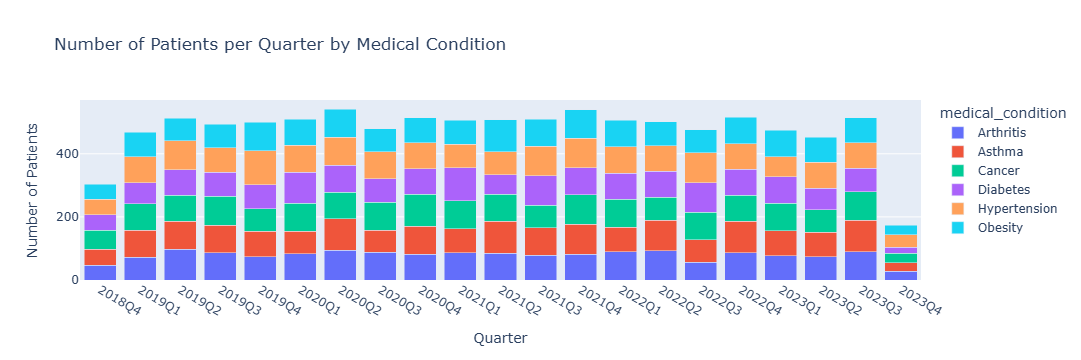

In [25]:
import pandas as pd
import plotly.express as px
from pyspark.sql import SparkSession

# Initialize Spark session (if not already done)
spark = SparkSession.builder \
    .appName("Healthcare Data Analysis") \
    .getOrCreate()

# Load data from Spark SQL
healthcare_data = spark.sql("SELECT * FROM healthcare_data")

# Convert the Spark DataFrame to Pandas DataFrame
df = healthcare_data.toPandas()

# Convert the 'Date of Admission' column to datetime
df['date_of_admission'] = pd.to_datetime(df['date_of_admission'])

# Extract quarter and year for grouping
df['YearQuarter'] = df['date_of_admission'].dt.to_period('Q').astype(str)

# Group by YearQuarter and Medical Condition and count the number of admissions
df_counts = df.groupby(['YearQuarter', 'medical_condition']).size().reset_index(name='Number of Patients')

# Display the aggregated DataFrame
print(df_counts)

# Create a bar plot
fig = px.bar(df_counts, 
             x='YearQuarter', 
             y='Number of Patients', 
             color='medical_condition', 
             title='Number of Patients per Quarter by Medical Condition',
             labels={'YearQuarter': 'Quarter', 'Number of Patients': 'Patients'},
             barmode='stack')

# Update layout for better visibility
fig.update_layout(xaxis_title='Quarter', yaxis_title='Number of Patients')

# Show the plot
fig.show()


In [53]:
from bokeh.io import curdoc

# Add layout to the current document
curdoc().add_root(layout)


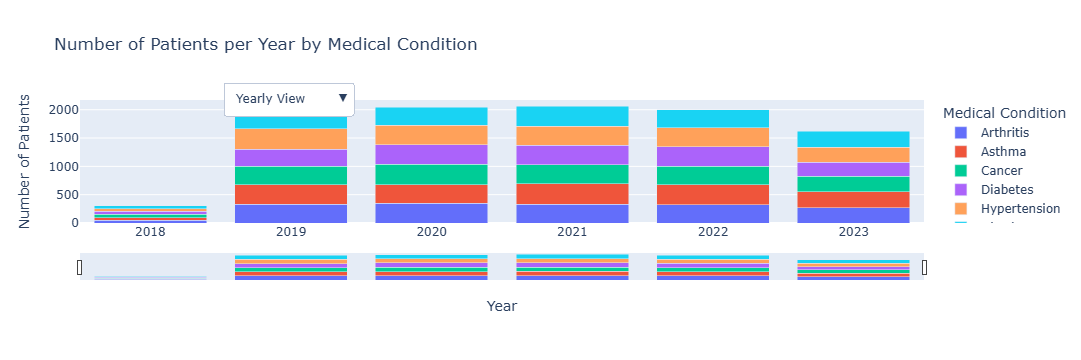

In [57]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pyspark.sql import SparkSession

# Initialize Spark session (if not already done)
spark = SparkSession.builder \
    .appName("Healthcare Data Analysis") \
    .getOrCreate()

# Load data from Spark SQL
healthcare_data = spark.sql("SELECT * FROM healthcare_data")

# Convert the Spark DataFrame to Pandas DataFrame
df = healthcare_data.toPandas()

# Convert the 'date_of_admission' column to datetime
df['date_of_admission'] = pd.to_datetime(df['date_of_admission'])

# Extract year and quarter for grouping
df['Year'] = df['date_of_admission'].dt.year
df['Quarter'] = df['date_of_admission'].dt.to_period('Q').astype(str)

# Aggregate data by year and quarter
df_yearly = df.groupby(['Year', 'medical_condition']).size().reset_index(name='Number of Patients')
df_quarterly = df.groupby(['Quarter', 'medical_condition']).size().reset_index(name='Number of Patients')

# Start by showing the yearly data
fig = px.bar(df_yearly, 
             x='Year', 
             y='Number of Patients', 
             color='medical_condition',
             title="Number of Patients per Year by Medical Condition",
             labels={'Number of Patients': 'Patients'},
             hover_data={'Year': True, 'medical_condition': True, 'Number of Patients': True},
             barmode='stack')

# Define the color palette manually
color_palette = px.colors.qualitative.Plotly  # Default Plotly color palette

# Add quarters as detailed view data for when the user zooms in
fig.add_trace(go.Bar(
    x=df_quarterly['Quarter'],
    y=df_quarterly['Number of Patients'],
    marker_color=color_palette[1],  # Using the second color in the palette as an example
    name="Quarterly Data",
    visible=False
))

# Customize layout to improve interaction
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Number of Patients",
    legend_title="Medical Condition",
    hovermode="x unified",
    updatemenus=[
        {
            "buttons": [
                {
                    "args": [{"visible": [True, False]}],
                    "label": "Yearly View",
                    "method": "update"
                },
                {
                    "args": [{"visible": [False, True]}],
                    "label": "Quarterly View",
                    "method": "update"
                }
            ],
            "direction": "down",
            "showactive": True,
            "x": 0.17,
            "y": 1.15,
            "xanchor": "left",
            "yanchor": "top",
        }
    ]
)

# Update x-axis with range slider
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

# Show the figure
fig.show()


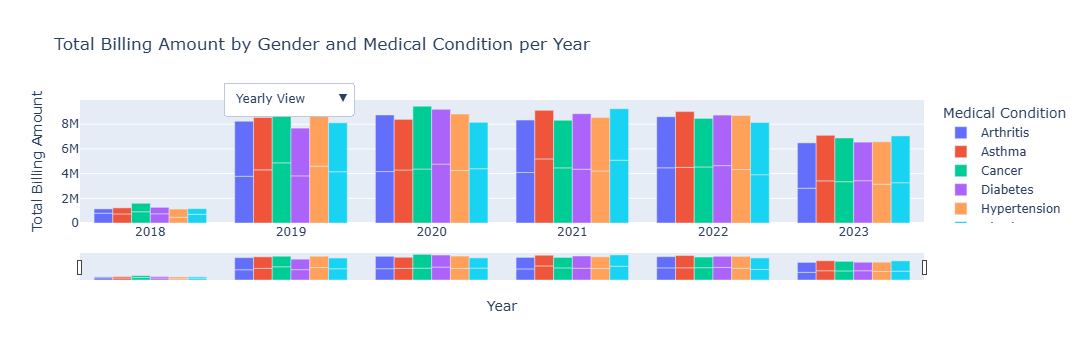

In [58]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# Load the healthcare data from Spark
healthcare_data = spark.sql("SELECT * FROM healthcare_data")

# Convert the Spark DataFrame to Pandas DataFrame
df = healthcare_data.toPandas()

# Convert the 'date_of_admission' column to datetime
df['date_of_admission'] = pd.to_datetime(df['date_of_admission'])

# Extract year and quarter from the 'date_of_admission' column
df['year'] = df['date_of_admission'].dt.year
df['quarter'] = df['date_of_admission'].dt.to_period('Q').astype(str)

# Group by Year, Medical Condition, and Gender, summing the Billing Amount (for yearly data)
df_billing_yearly = df.groupby(['year', 'medical_condition', 'Gender'])['billing_amount'].sum().reset_index()

# Group by Quarter, Medical Condition, and Gender, summing the Billing Amount (for quarterly data)
df_billing_quarterly = df.groupby(['quarter', 'medical_condition', 'Gender'])['billing_amount'].sum().reset_index()

# Create the initial figure for yearly billing amounts
fig_billing = px.bar(
    df_billing_yearly,
    x='year', 
    y='billing_amount', 
    color='medical_condition', 
    barmode='group',
    title='Total Billing Amount by Gender and Medical Condition per Year',
    labels={'year': 'Year', 'billing_amount': 'Total Billing Amount'},
)

# Add the quarterly data as a separate trace, initially hidden
fig_billing.add_trace(go.Bar(
    x=df_billing_quarterly['quarter'],
    y=df_billing_quarterly['billing_amount'],
    marker_color=px.colors.qualitative.Plotly[1],  # Using second color in the default Plotly palette
    name="Quarterly Billing Data",
    visible=False
))

# Add an update menu for selecting between yearly and quarterly views
fig_billing.update_layout(
    xaxis_title='Year',
    yaxis_title='Total Billing Amount',
    legend_title='Medical Condition',
    updatemenus=[
        {
            "buttons": [
                {
                    "args": [{"visible": [True, False]}],  # Show only yearly data
                    "label": "Yearly View",
                    "method": "update"
                },
                {
                    "args": [{"visible": [False, True]}],  # Show only quarterly data
                    "label": "Quarterly View",
                    "method": "update"
                }
            ],
            "direction": "down",
            "showactive": True,
            "x": 0.17,
            "y": 1.15,
            "xanchor": "left",
            "yanchor": "top",
        }
    ]
)

# Update x-axis with a range slider to facilitate interaction
fig_billing.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

# Show the interactive plot
fig_billing.show()


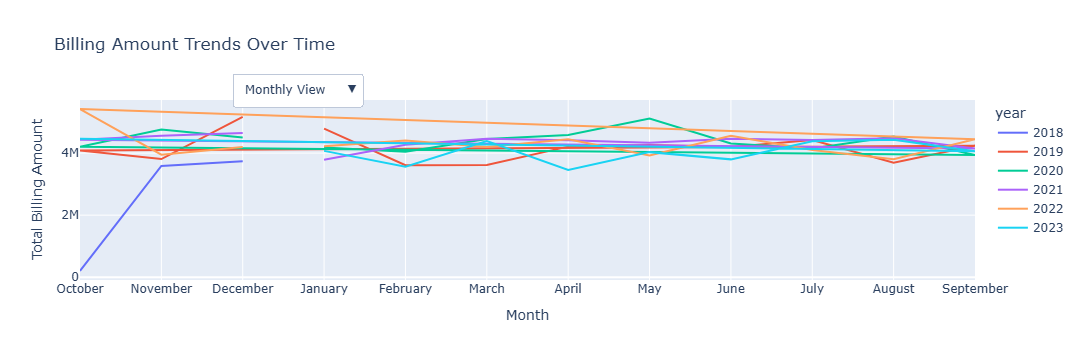

In [59]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Assuming df has already been created and contains 'date_of_admission' and 'billing_amount' columns

# Convert 'date_of_admission' to datetime if not already done
df['date_of_admission'] = pd.to_datetime(df['date_of_admission'])

# Extract Year, Month, and Quarter from 'date_of_admission'
df['year'] = df['date_of_admission'].dt.year
df['month'] = df['date_of_admission'].dt.month_name()  # Use dt.month for numeric month if preferred
df['quarter'] = df['date_of_admission'].dt.to_period('Q').astype(str)

# Group by Year and Month for monthly trends
df_monthly = df.groupby(['year', 'month'])['billing_amount'].sum().reset_index()

# Group by Year and Quarter for quarterly trends
df_quarterly = df.groupby(['year', 'quarter'])['billing_amount'].sum().reset_index()

# Set month as a categorical variable to ensure proper sorting
df_monthly['month'] = pd.Categorical(
    df_monthly['month'],
    categories=["January", "February", "March", "April", "May", "June", 
                "July", "August", "September", "October", "November", "December"],
    ordered=True
)

# Sort by year and month
df_monthly = df_monthly.sort_values(['year', 'month'])

# Create the initial figure for monthly billing amount trends
fig_trend = px.line(
    df_monthly,
    x='month',
    y='billing_amount',
    color='year',
    title='Billing Amount Trends Over Time',
    labels={'month': 'Month', 'billing_amount': 'Total Billing Amount'}
)

# Add the quarterly data trace, initially hidden
for year in df_quarterly['year'].unique():
    quarterly_data = df_quarterly[df_quarterly['year'] == year]
    fig_trend.add_trace(go.Scatter(
        x=quarterly_data['quarter'],
        y=quarterly_data['billing_amount'],
        mode='lines+markers',
        name=f"Quarterly {year}",
        visible=False
    ))

# Add an update menu for toggling between monthly and quarterly data
fig_trend.update_layout(
    updatemenus=[
        {
            "buttons": [
                {
                    "args": [{"visible": [True] * len(df_monthly['year'].unique()) + [False] * len(df_quarterly['year'].unique())}],
                    "label": "Monthly View",
                    "method": "update"
                },
                {
                    "args": [{"visible": [False] * len(df_monthly['year'].unique()) + [True] * len(df_quarterly['year'].unique())}],
                    "label": "Quarterly View",
                    "method": "update"
                }
            ],
            "direction": "down",
            "showactive": True,
            "x": 0.17,
            "y": 1.15,
            "xanchor": "left",
            "yanchor": "top"
        }
    ]
)

# Show the interactive plot
fig_trend.show()


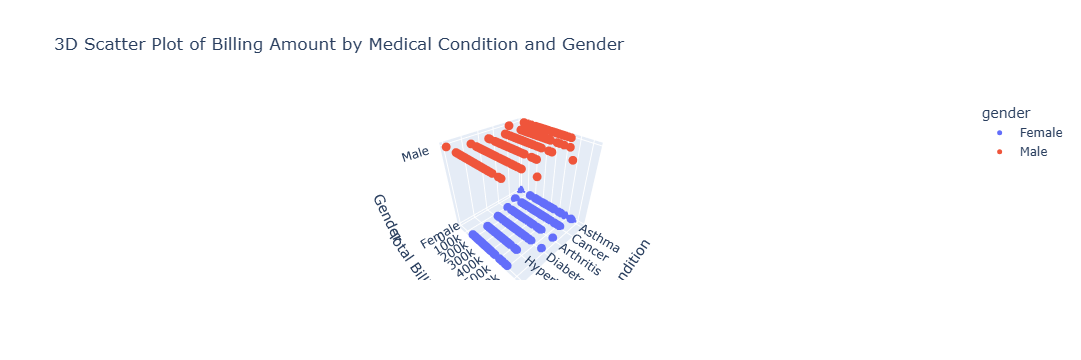

In [21]:
import plotly.express as px
import pandas as pd

# Load data from Spark
healthcare_data = spark.sql("SELECT * FROM healthcare_data")

# Convert the Spark DataFrame to a Pandas DataFrame
df = healthcare_data.toPandas()

# Convert the 'Date of Admission' column to datetime
df['date_of_admission'] = pd.to_datetime(df['date_of_admission'])

# Extract month and year for grouping
df['YearMonth'] = df['date_of_admission'].dt.to_period('M').astype(str)

# Ensure all columns are lowercase to match your data schema
df.columns = df.columns.str.lower()

# Verify 'billing_amount' column is numeric (convert if necessary)
df['billing_amount'] = pd.to_numeric(df['billing_amount'], errors='coerce')

# Filter out any missing or invalid data
df = df.dropna(subset=['medical_condition', 'billing_amount', 'gender'])

# Group by 'YearMonth', 'medical_condition', 'gender' and aggregate 'billing_amount'
df_counts = df.groupby(['yearmonth', 'medical_condition', 'gender'])['billing_amount'].sum().reset_index()

# Create a 3D scatter plot with Plotly Express
fig = px.scatter_3d(
    df_counts,
    x='medical_condition',    # Medical Condition on the x-axis
    y='billing_amount',       # Billing Amount on the y-axis
    z='gender',               # Gender on the z-axis
    color='gender',           # Color by Gender for differentiation
    title="3D Scatter Plot of Billing Amount by Medical Condition and Gender"
)

# Customize markers and layout for visibility
fig.update_traces(marker=dict(size=5))
fig.update_layout(scene=dict(
    xaxis_title='Medical Condition',
    yaxis_title='Total Billing Amount',
    zaxis_title='Gender'
))

# Show the plot
fig.show()


  YearMonth medical_condition  Gender  total_billing_amount
0   2018-10            Asthma  Female          15276.018269
1   2018-10            Asthma    Male          50016.886438
2   2018-10            Cancer  Female          80689.502754
3   2018-10            Cancer    Male          19060.231547
4   2018-10           Obesity    Male          34485.490479


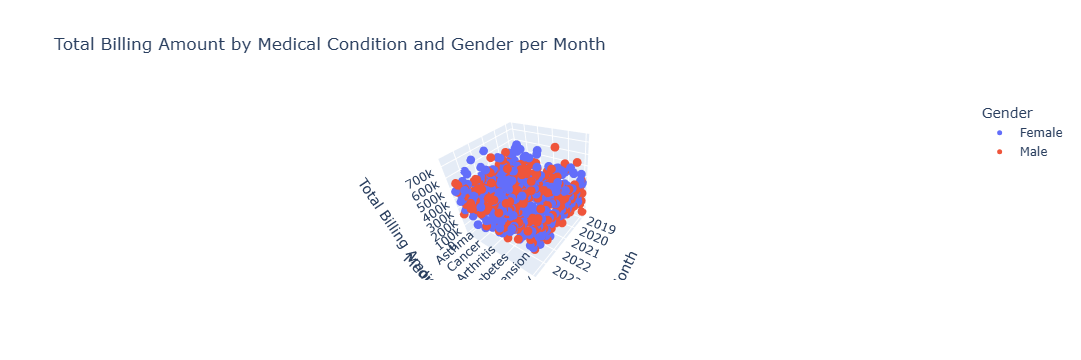

In [20]:
import pandas as pd
from pyspark.sql import functions as F

# Load your healthcare data (assuming you already have this part)
healthcare_data = spark.sql("SELECT * FROM healthcare_data")

# Convert the Spark DataFrame to Pandas DataFrame
df = healthcare_data.toPandas()

# Convert the 'Date of Admission' column to datetime
df['date_of_admission'] = pd.to_datetime(df['date_of_admission'])

# Extract Year and Month for grouping
df['YearMonth'] = df['date_of_admission'].dt.to_period('M').astype(str)

# Group by YearMonth, Medical Condition, and Gender to calculate total billing amount
df_billing = df.groupby(['YearMonth', 'medical_condition', 'Gender'])['billing_amount'].sum().reset_index()

# Rename columns if needed for clarity
df_billing.columns = ['YearMonth', 'medical_condition', 'Gender', 'total_billing_amount']

# Display the first few rows of df_billing to verify
print(df_billing.head())
import plotly.express as px

# Assuming df_billing has the columns 'YearMonth', 'medical_condition', 'Gender', 'total_billing_amount'
fig = px.scatter_3d(
    df_billing,
    x='YearMonth',            # Monthly data on the x-axis
    y='medical_condition',     # Medical condition on the y-axis
    z='total_billing_amount',  # Total billing amount on the z-axis
    color='Gender',           # Color by Gender for distinction
    title="Total Billing Amount by Medical Condition and Gender per Month"
)

# Update marker and layout for clarity
fig.update_traces(marker=dict(size=5))
fig.update_layout(scene=dict(
    xaxis_title='Month',
    yaxis_title='Medical Condition',
    zaxis_title='Total Billing Amount'
))

# Show the plot
fig.show()


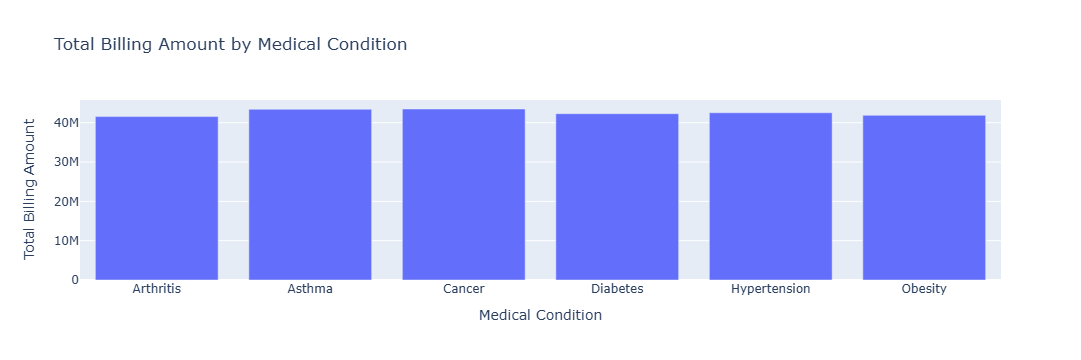

In [21]:
# Grouping by medical condition to get total billing amounts
df_condition_billing = df.groupby('medical_condition')['billing_amount'].sum().reset_index()

# Creating a bar plot for total billing amounts by medical condition
fig_condition_billing = px.bar(
    df_condition_billing,
    x='medical_condition',
    y='billing_amount',
    title='Total Billing Amount by Medical Condition',
    labels={'medical_condition': 'Medical Condition', 'billing_amount': 'Total Billing Amount'}
)
fig_condition_billing.show()


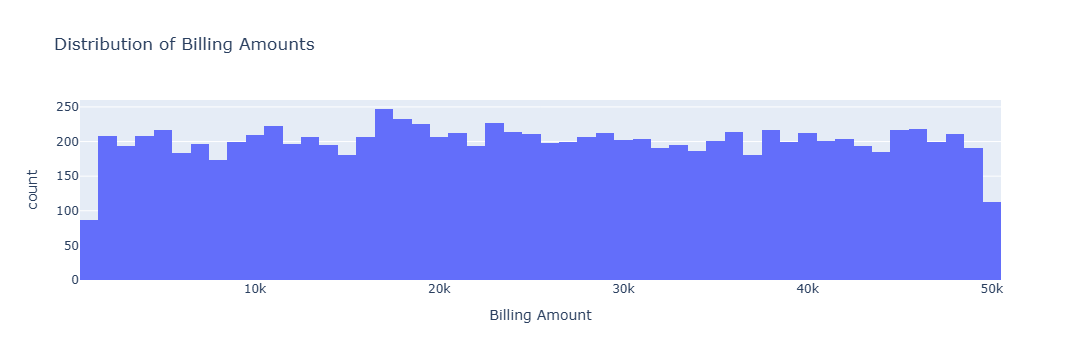

In [22]:
# Creating a histogram of billing amounts
fig_hist = px.histogram(
    df,
    x='billing_amount',
    title='Distribution of Billing Amounts',
    labels={'billing_amount': 'Billing Amount'}
)
fig_hist.show()


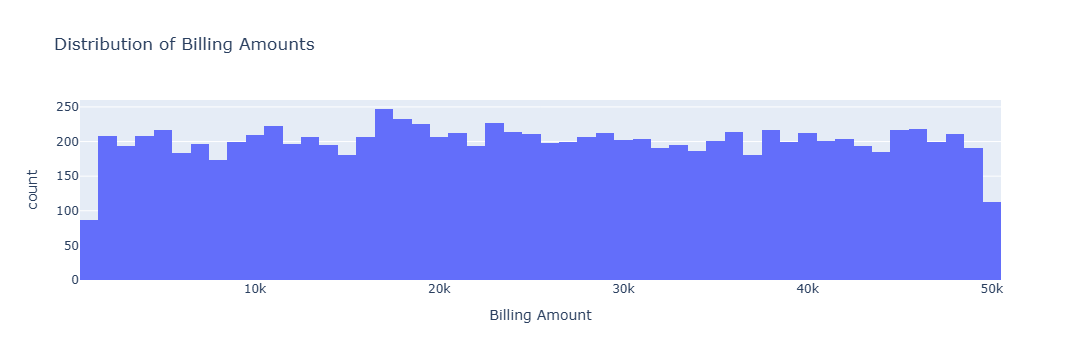

In [23]:
# Creating a histogram of billing amounts
fig_hist = px.histogram(
    df,
    x='billing_amount',
    title='Distribution of Billing Amounts',
    labels={'billing_amount': 'Billing Amount'}
)
fig_hist.show()


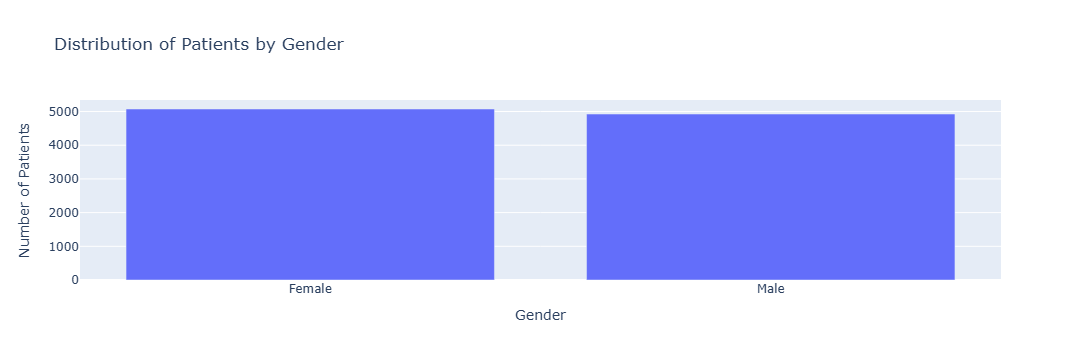

In [25]:
# Counting the number of patients by gender
df_gender_distribution = df['Gender'].value_counts().reset_index()
df_gender_distribution.columns = ['Gender', 'number_of_patients']

# Creating a bar plot for gender distribution
fig_gender = px.bar(
    df_gender_distribution,
    x='Gender',
    y='number_of_patients',
    title='Distribution of Patients by Gender',
    labels={'Gender': 'Gender', 'number_of_patients': 'Number of Patients'}
)
fig_gender.show()
